In [1]:
import csv
import cv2
import numpy as np
import tensorflow as tf
import os
import keras
from keras.models import Sequential
from keras.layers.core import Lambda, Dense, Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Cropping2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [29]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
print(tf.__version__)
# run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        lines.append(line)

train_samples, validation_samples = train_test_split(lines, test_size=0.2)

def generator(samples, batch_size=32):
    num_samples = len(samples)
    batch_size = batch_size // 2
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = './data/IMG/'+batch_sample[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                # image augment by flipping.
                image_flipped = np.fliplr(center_image)
                measurement_flipped = -center_angle
                images.append(image_flipped)
                angles.append(measurement_flipped)
            
            # trim image to only see section with road
            X_train = np.array(images)
            
            # print(len(images), X_train.shape)
            
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

1.5.0


the original shape of image (160, 320, 3)


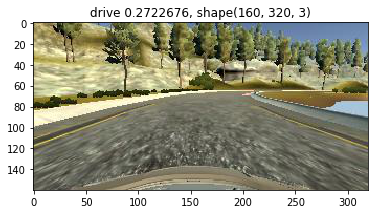

In [39]:
# test generator
_test_generator = generator(train_samples)
_test_data = next(_test_generator)
images = _test_data[0]
print('the original shape of image {}'.format(images[0].shape))
angles = _test_data[1]
index = np.random.randint(16)
plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
plt.title("drive {}, shape{}".format(angles[index], images[index].shape))

In [38]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [40]:
ch, row, col = 3, 160, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=(row, col, ch)))
# model.add(Lambda(normalized_image, input_shape=(160, 320, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
# model.compile(loss='mse', optimizer='adam')
callback = keras.callbacks.TensorBoard(log_dir='./logs')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, batch_size=32, epochs=30, callbacks=callback)
# for generator
model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, steps_per_epoch=200, epochs=3)
model.save('model.h5')

/home/yoshie/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), activation="relu")`
/home/yoshie/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), activation="relu")`
/home/yoshie/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), activation="relu")`
/home/yoshie/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
/home/yoshie/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activatio

Epoch 1/3
200/200 [==============================] - 8s 39ms/step - loss: 2.3041
Epoch 2/3
200/200 [==============================] - 7s 33ms/step - loss: 0.0151
Epoch 3/3
200/200 [==============================] - 6s 32ms/step - loss: 0.0113


In [10]:
_ge_train = next(train_generator)

In [11]:
len(_ge_train)

2

In [13]:
_ge_train[0].shape

(64, 160, 320, 3)

In [14]:
_ge_train[1].shape

(64,)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 37, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 35, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 33, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 27456)             0         
__________